In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None

## Import Datsets

### Train and Test Data

In [5]:
train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
id                   78369 non-null int64
campaign_id          78369 non-null int64
coupon_id            78369 non-null int64
customer_id          78369 non-null int64
redemption_status    78369 non-null int64
dtypes: int64(5)
memory usage: 3.0 MB


In [6]:
test = pd.read_csv('data/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50226 entries, 0 to 50225
Data columns (total 4 columns):
id             50226 non-null int64
campaign_id    50226 non-null int64
coupon_id      50226 non-null int64
customer_id    50226 non-null int64
dtypes: int64(4)
memory usage: 1.5 MB


In [8]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [9]:
test.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


- Train and Test have IDs to other tables' data (like foreign keys); so we will need to merge with ohter tables
- Target variable is *redemption_status* which means if the custoemr redeemed the coupon or not.

In [10]:
# save ids for creating submission file later
test_ids = test['id'].values

### Campaign Data

In [11]:
campaigns = pd.read_csv('data/campaign_data.csv')
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
campaign_id      28 non-null int64
campaign_type    28 non-null object
start_date       28 non-null object
end_date         28 non-null object
dtypes: int64(1), object(3)
memory usage: 976.0+ bytes


In [12]:
campaigns.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


Converting *start_date*, *end_date* to datetime type

In [13]:
dateparser = lambda s : pd.datetime.strptime(s, '%d/%m/%y')
campaigns['start_date'] = campaigns['start_date'].apply(dateparser)
campaigns['end_date'] = campaigns['end_date'].apply(dateparser)
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
campaign_id      28 non-null int64
campaign_type    28 non-null object
start_date       28 non-null datetime64[ns]
end_date         28 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 976.0+ bytes


The *start_date* and *end_date* of a campaign will not have much effet on coupon redemption.  
However, duration of a campaign could be a useful variable.

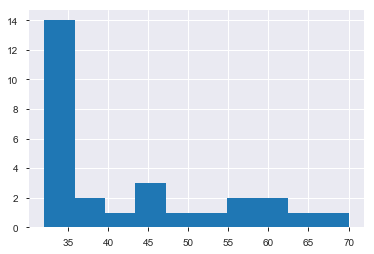

In [14]:
campaigns['campaign_duration'] = (campaigns['end_date'] - campaigns['start_date']).dt.days
plt.hist(campaigns['campaign_duration'])
plt.show()

In [15]:
campaigns.drop(['start_date','end_date'], axis=1,inplace=True)
campaigns.head()

,campaign_id,campaign_type,campaign_duration
0,24,Y,60
1,25,Y,32
2,20,Y,70
3,23,Y,38
4,21,Y,32


Performing label Encoding for the categorical variable, *campaign_type*

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
campaigns['campaign_type'] = le.fit_transform(campaigns['campaign_type'])
campaigns.head()

,campaign_id,campaign_type,campaign_duration
0,24,1,60
1,25,1,32
2,20,1,70
3,23,1,38
4,21,1,32


In [17]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
campaign_id          28 non-null int64
campaign_type        28 non-null int32
campaign_duration    28 non-null int64
dtypes: int32(1), int64(2)
memory usage: 640.0 bytes


### Coupon Item Mapping

In [19]:
coupon_item_map = pd.read_csv('data/coupon_item_mapping.csv')
coupon_item_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
coupon_id    92663 non-null int64
item_id      92663 non-null int64
dtypes: int64(2)
memory usage: 1.4 MB


In [20]:
coupon_item_map.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


Coupons Table just maps each coupon to the items it applies to. So will need to merge this with the *items* table

### Items Data

In [21]:
items = pd.read_csv('data/item_data.csv')
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
item_id       74066 non-null int64
brand         74066 non-null int64
brand_type    74066 non-null object
category      74066 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [22]:
items.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


- All columns are categorical

In [23]:
print('Number of unique values in each column:')
for col in items.columns[1:]:
    print(col,':')
    print('nunique =', items[col].nunique())
    print('unique =', items[col].unique())
    print()

Number of unique values in each column:
brand :
nunique = 5528
unique = [   1   56   11 ... 5463 2997 3360]

brand_type :
nunique = 2
unique = ['Established' 'Local']

category :
nunique = 19
unique = ['Grocery' 'Miscellaneous' 'Bakery' 'Pharmaceutical' 'Packaged Meat'
 'Seafood' 'Natural Products' 'Dairy, Juices & Snacks' 'Prepared Food'
 'Skin & Hair Care' 'Meat' 'Travel' 'Flowers & Plants' 'Fuel' 'Salads'
 'Alcohol' 'Garden' 'Restauarant' 'Vegetables (cut)']



- Perform label encoding on all three variables

In [24]:
# established = 1, local = 0
items['established'] = (items['brand_type'] == 'Established').astype(int)
items.drop('brand_type',axis=1,inplace=True)

In [25]:
le = LabelEncoder()
for col in ['brand', 'category']:
    items[col] = le.fit_transform(items[col])
items.head()

,item_id,brand,category,established
0,1,0,6,1
1,2,0,8,1
2,3,55,1,0
3,4,55,6,0
4,5,55,6,0


In [26]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
item_id        74066 non-null int64
brand          74066 non-null int64
category       74066 non-null int32
established    74066 non-null int32
dtypes: int32(2), int64(2)
memory usage: 1.7 MB


### Customer Demographic Data

In [27]:
customers = pd.read_csv('data/customer_demographics.csv')
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760 non-null object
marital_status    431 non-null object
rented            760 non-null int64
family_size       760 non-null object
no_of_children    222 non-null object
income_bracket    760 non-null int64
dtypes: int64(3), object(4)
memory usage: 41.6+ KB


In [28]:
customers.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


- All the variables in this table are categorical

In [29]:
print('Unique categories:')
for col in customers.columns[1:]:
    print(col,':',customers[col].unique())

Unique categories:
age_range : ['70+' '46-55' '26-35' '36-45' '18-25' '56-70']
marital_status : ['Married' nan 'Single']
rented : [0 1]
family_size : ['2' '3' '4' '1' '5+']
no_of_children : [nan '1' '2' '3+']
income_bracket : [ 4  5  3  6  1  7  2  8  9 12 10 11]


#### Missing Values

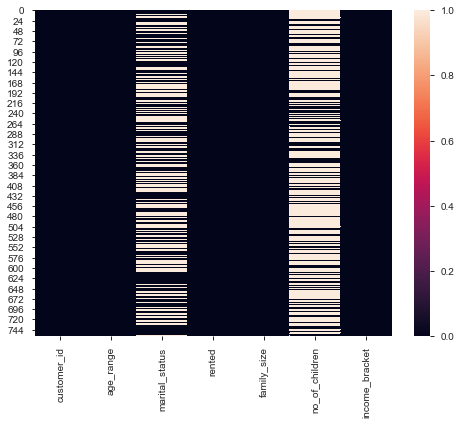

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(customers.isnull())
plt.show()

Missing values exist only in two columns, *marital_status* and *no_of_children*

#### No of Children

In [31]:
customers['no_of_children'].value_counts()

1     107
3+     60
2      55
Name: no_of_children, dtype: int64

- All the existing values in this columns are 1, 2, 3+
- The missing values are probably those with *no_of_children* = 0

In [32]:
customers['no_of_children'].fillna('0', inplace=True)

In [33]:
customers['no_of_children'].value_counts()

0     538
1     107
3+     60
2      55
Name: no_of_children, dtype: int64

#### Marital Status

In [34]:
customers['marital_status'].value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [35]:
customers['marital_status'].isnull().sum()

329

- There are only two categories in this column, *Married* and *Single*
- The missing values should be imputed with one of these

Looking at the distribution of *Married*/*Single* across all categories of other columns:

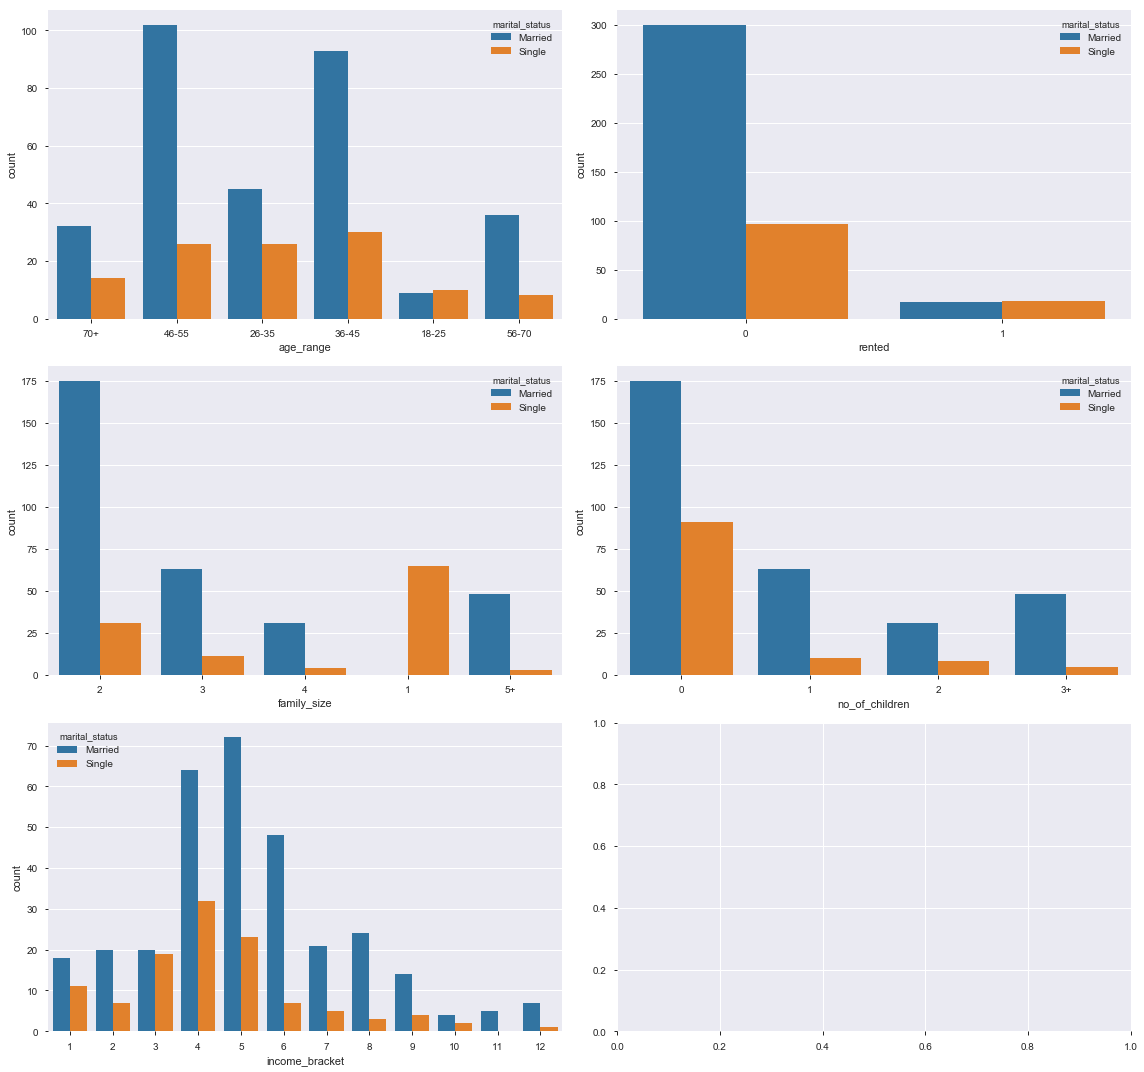

In [36]:
fig,ax = plt.subplots(3,2,figsize=(16,15))
ax = ax.flatten()
ax_i = 0
for col in customers.columns[1:]:
    if col != 'marital_status':
        sns.countplot(x=col,hue='marital_status',data=customers,ax=ax[ax_i])
        ax_i = ax_i+1

plt.tight_layout()
plt.show()

- Observe that for all *family_size*=1 rows we have *marital_status*=*Single* which makes sense
- For all other categories of *family_size*, 2,3,4,5+ *Married* values dominates but *Single* values still exist

Logically, *family_size* = 1 means you are defintely *Single*.  
If *family_size* > 1 we canNOT conlcude he/she is *Married* since a person can have children and still be *Single*. But, your children would definitely add to your *family_size*. So we can use *family_size* and *no_of_children* to impute missing values for *marital_status*.  

*family_size* would include the person itself as well as possible spouse and children.  
If *family_size* = *no_of_children* + 1 then we can conclude he/she is *Single*.  
If *family_size* = *no_of_children* + 2 he/she is *Married*.  

The only case where this could go wrong is cases where *family_size*=5+ and *no_of_children*=3+ since we cannot know the exact numbers in these cases. But for now, disregarding this and imputing accordingly

In [37]:
customers['family_size'] = customers['family_size'].str.replace('+','').astype(int)
customers['no_of_children'] = customers['no_of_children'].str.replace('+','').astype(int)

In [38]:
(customers['family_size'] - customers['no_of_children']).value_counts()

2    486
1    274
dtype: int64

- For all cases where the difference is 1, we impute *Single*
- For all cases where the difference is 2, we impute *Married*

In [39]:
customers.loc[customers['marital_status'].isnull() & 
            (customers['family_size'] - customers['no_of_children'] == 1), 'marital_status'] = 'Single'

customers.loc[customers['marital_status'].isnull() & 
            (customers['family_size'] - customers['no_of_children'] == 2), 'marital_status'] = 'Married'

In [40]:
customers.isnull().sum()

customer_id       0
age_range         0
marital_status    0
rented            0
family_size       0
no_of_children    0
income_bracket    0
dtype: int64

#### Age Range

In [41]:
customers['age_range'].unique()

array(['70+', '46-55', '26-35', '36-45', '18-25', '56-70'], dtype=object)

Converting *age_range* column to type int by taking mean of each age range.  
In case of *70+* will just leave it as 70.

In [42]:
from statistics import mean
customers['age_range'] = customers['age_range'].str.replace('+','-70')
customers['age_range'] = customers['age_range'].apply( lambda s : int((int(s[:2]) + int(s[-2:])) / 2) )

*marital_status*, *rented* and *income_bracket* are categorical columns.  
*rented* and *income_bracket* are already label encoded
Performing Label Encoding for *marital_status*:

In [43]:
le = LabelEncoder()
customers['marital_status'] = le.fit_transform(customers['marital_status'])
customers.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70,0,0,2,0,4
1,6,50,0,0,2,0,5
2,7,30,0,0,3,1,3
3,8,30,0,0,4,2,6
4,10,50,1,0,1,0,5


In [44]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760 non-null int64
marital_status    760 non-null int32
rented            760 non-null int64
family_size       760 non-null int32
no_of_children    760 non-null int32
income_bracket    760 non-null int64
dtypes: int32(3), int64(4)
memory usage: 32.7 KB


### Customer Transaction Data

In [45]:
transactions = pd.read_csv('data/customer_transaction_data.csv')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null object
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [46]:
transactions.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


There are no missing values in this table.

Converting *date* to datetime type

In [47]:
dateparser = lambda s : pd.datetime.strptime(s, '%Y-%m-%d')
transactions['date'] = transactions['date'].apply(dateparser)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null datetime64[ns]
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


Looking at distribution of data for numerical columns

In [48]:
transactions.columns

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount'],
      dtype='object')

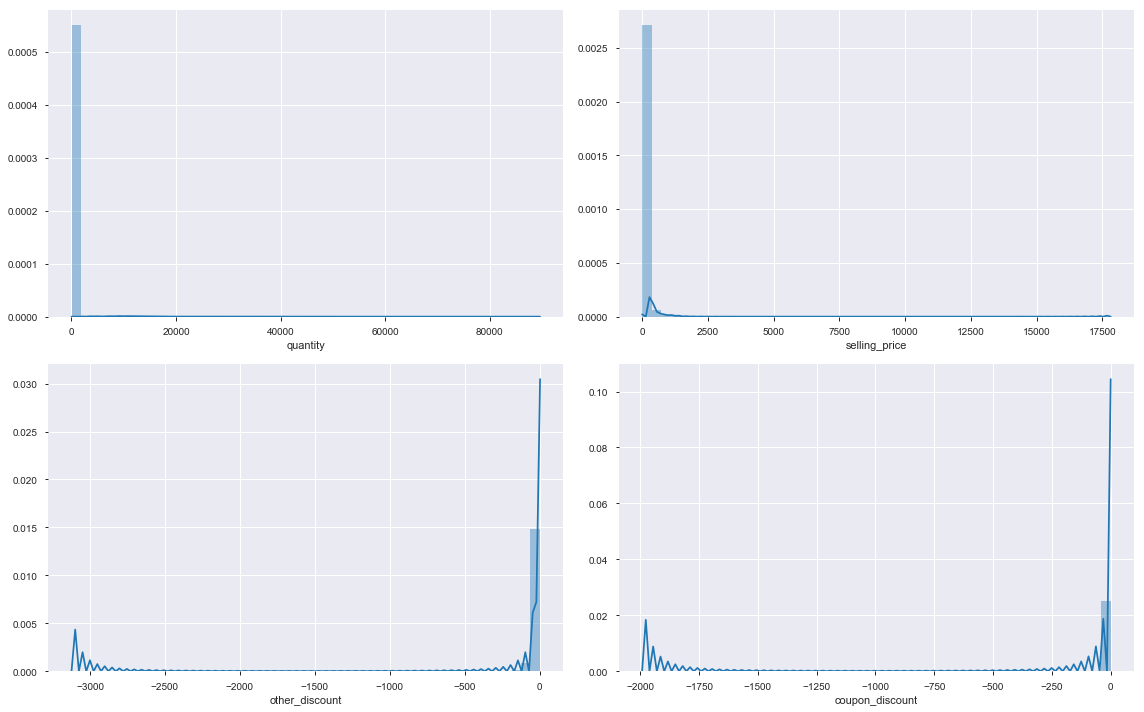

In [49]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
ax = ax.flatten()
for i,col in enumerate(['quantity', 'selling_price', 'other_discount', 'coupon_discount']):
    sns.distplot(transactions[col],ax=ax[i])
plt.tight_layout()
plt.show()

In [50]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null datetime64[ns]
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


In [51]:
transactions.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


## Merging/Aggregating Datasets

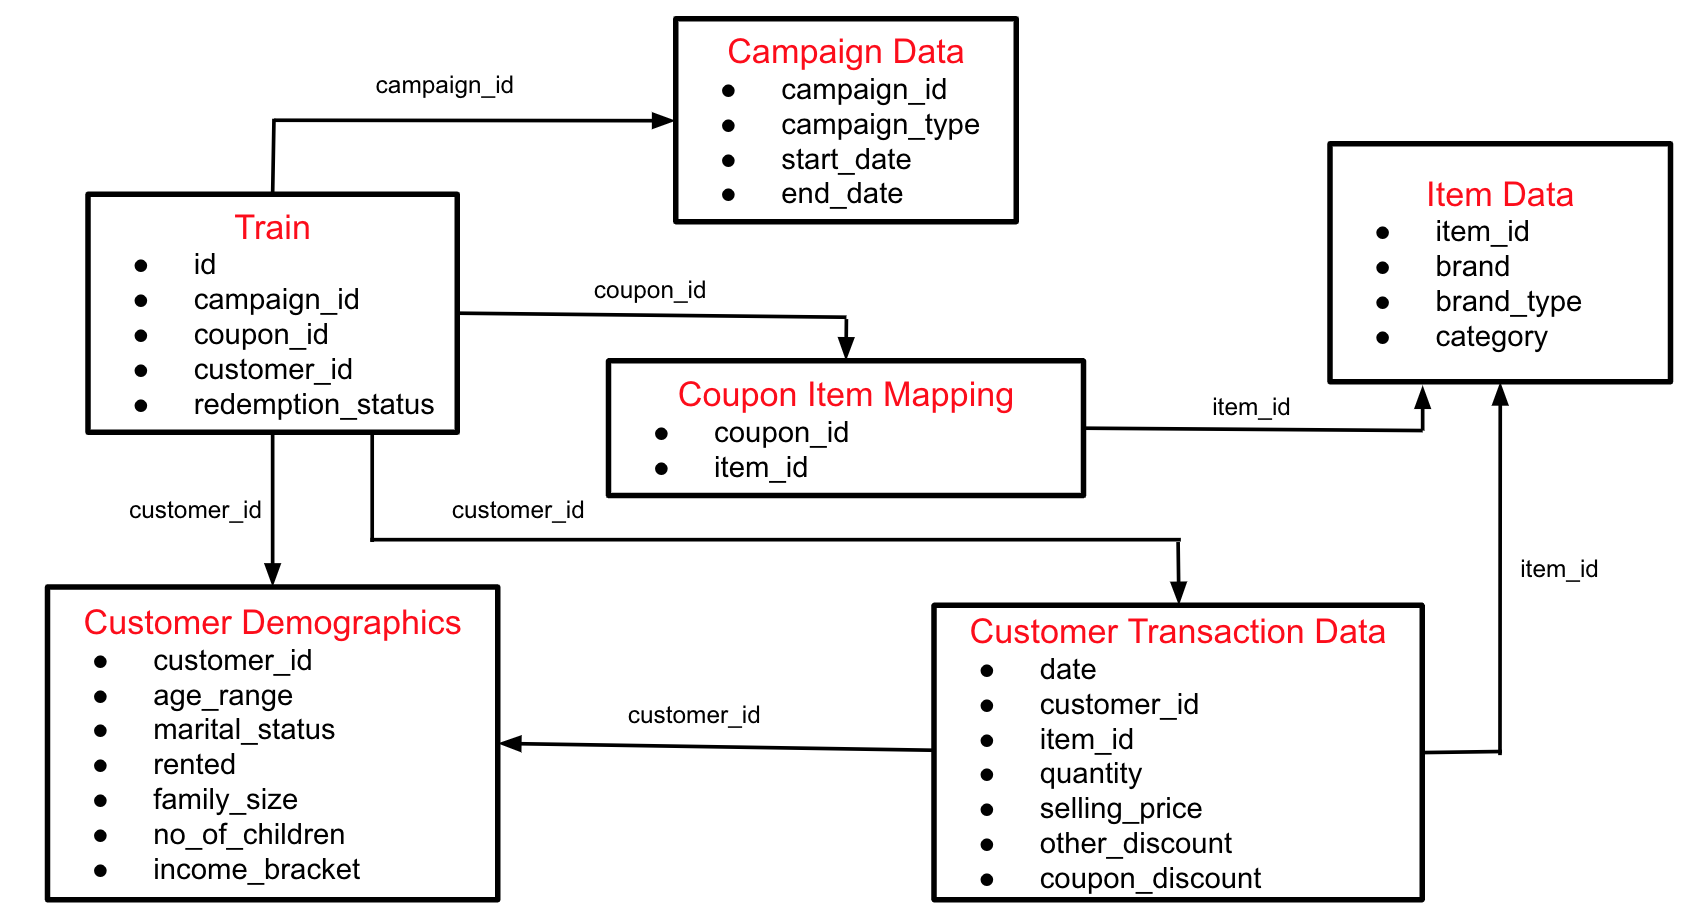

In [108]:
from IPython.display import Image
Image('images/schema.png')

Primary keys for each table:
- Train: {*id*}
- Campaign: {*campaign_id*}
- Customer Demographics: {*customer_id*}
- Item: {*item_id*}
- Coupon Item: {*coupon_id*, *item_id*}
- Customer Transaction: {*customer_id*, *item_id*}

Creating some extra fetaures for each campaign:
- number of coupons per campaign
- number of customers per campaign

We will get this from the *train* and *test* tables.

In [53]:
num_unique = lambda x:x.nunique()

In [54]:
campaign_features = pd.concat([train,test]).groupby('campaign_id').agg({'coupon_id':num_unique,'customer_id':num_unique})
campaign_features.rename(columns={'coupon_id':'coupons_nunique', 'customer_id':'customers_nunique'},inplace=True)

campaign_features = pd.merge(campaigns, campaign_features, on='campaign_id', how='inner')
campaign_features.head()

,campaign_id,campaign_type,campaign_duration,coupons_nunique,customers_nunique
0,24,1,60,2,100
1,25,1,32,17,187
2,20,1,70,24,244
3,23,1,38,18,183
4,21,1,32,16,65


### Coupon-Items

Merging *coupons* and *items* on *item_id*:

In [55]:
coupon_items = pd.merge(coupon_item_map, items, on='item_id', how='inner')
coupon_items.head()

,coupon_id,item_id,brand,category,established
0,105,37,55,6,0
1,6,37,55,6,0
2,22,37,55,6,0
3,31,37,55,6,0
4,107,75,55,6,0


Since we will eventually be merging *train*/*test* with this on *coupon_id*, let's aggreagte this new merged table based on *coupon_id*.  
New variables will be:
- Number of unique items
- Number of unique brands
- Number of unique categories
- Mean of established (which will give fraction of total items that are form established brands)

In [56]:
aggfunc = {'item_id':num_unique, 'brand': num_unique, 'category':num_unique, 'established':'mean'}
aggfunc

{'item_id': <function __main__.<lambda>(x)>,
 'brand': <function __main__.<lambda>(x)>,
 'category': <function __main__.<lambda>(x)>,
 'established': 'mean'}

In [57]:
coupons = coupon_items.groupby('coupon_id').agg(aggfunc).reset_index()
coupons.rename(columns={'item_id':'coupon_item_nunique', 'brand':'coupon_brand_nunique',
                        'established':'coupon_established_mean', 
                        'category':'coupon_category_nunique'},inplace=True)
coupons.head()

,coupon_id,coupon_item_nunique,coupon_brand_nunique,coupon_category_nunique,coupon_established_mean
0,1,39,3,2,1.0
1,2,2,1,1,1.0
2,3,17,2,1,1.0
3,4,24,1,1,1.0
4,5,7,1,1,1.0


### Transaction-Items

Merging *transactions* with *items*

In [58]:
transaction_items = pd.merge(transactions, items, on='item_id', how='inner')
transaction_items.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,brand,category,established
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,55,9,0
1,2012-01-02,135,26830,1,35.26,-10.69,0.0,55,9,0
2,2012-01-02,464,26830,1,35.26,-10.69,0.0,55,9,0
3,2012-01-12,1185,26830,1,45.95,0.00,0.0,55,9,0
4,2012-01-13,1140,26830,1,45.95,0.00,0.0,55,9,0


Since we will eventually be merging *train*/*test* with this on *customer_id*, let's aggreagte this new merged table based on *customer_id*. This table will represent customer purchasing history  
New variables will be:
- Number of unique dates (how often the customer purchases)
- Sum and Mean of *quantity* (how many items the customer purchases)
- Sum and Mean of *selling_price* (how much amount customer spends)
- Sum and Mean of *other_discount* (how much discount customer applies from other sources)
- Sum and Mean of *coupon_discount* (how much discount customer applies from coupons)

In [59]:
aggfunc = {
    'date':num_unique, 'quantity':['sum','mean'], 'selling_price':['sum','mean'],
    'other_discount':['sum','mean'], 'coupon_discount':['sum','mean']}

In [60]:
customer_purchases = transaction_items.groupby('customer_id').agg(aggfunc).reset_index()
customer_purchases.columns = ['customer_id', 'date_nunique', 'quantity_sum', 'quantity_mean', 
                          'selling_price_sum', 'selling_price_mean', 'other_discount_sum', 'other_discount_mean',
                          'coupon_discount_sum', 'coupon_discount_mean']
customer_purchases.head()

,customer_id,date_nunique,quantity_sum,quantity_mean,selling_price_sum,selling_price_mean,other_discount_sum,other_discount_mean,coupon_discount_sum,coupon_discount_mean
0,1,56,1227,1.170802,98513.93,94.001842,-17030.40,-16.250382,-2116.83,-2.019876
1,2,37,474,1.131265,43100.03,102.864033,-7051.95,-16.830430,-249.34,-0.595084
2,3,41,8163,11.578723,73050.27,103.617404,-16013.53,-22.714227,-2179.54,-3.091546
3,4,26,280,1.272727,33973.22,154.423727,-2927.19,-13.305409,-89.05,-0.404773
4,5,163,93353,117.869949,103615.10,130.827146,-10817.07,-13.657917,-90.83,-0.114684


### Customer Demographics

In [61]:
print('Number of unique customer_id in all the tables:')
print('Train :', train['customer_id'].nunique())
print('Test :', test['customer_id'].nunique())
print('Transactions :', transactions['customer_id'].nunique())
print('Demographics :', customers['customer_id'].nunique())

Number of unique customer_id in all the tables:
Train : 1428
Test : 1250
Transactions : 1582
Demographics : 760


If you observe the values above, Customer Demographics table only has info for 760 customers from a total of 1582 possible customers (as seen in *transactions* table). This is only 48% of customers.  

Given that more than half of the customers are missing from this table, this table would NOT be very useful to us. When we merge with *trian*/*test* tables, this will give us lots of *NaN* values. We need to figure out a reliable way to impute this null values otherwise this table cannot be used.  

If the missing value were only 5-10%, we can impute with central tendencies, clustering or regression to impute these values but 52% missing data is too much to do reliable imputing. 

Hence, I am not using this table for building my model.  

Note: I have tried left merging anyways and applying XGBoost and LightGBM since these algorithms can handle missing values internally. But, this did not help improve the accuracy much.

### Train/Test

Merge all the tables to *train* and *test*

In [62]:
train.shape

(78369, 5)

Merging *train* with *campaigns*,*coupons* and *customer_purchases* on *campaign_id*, *coupon_id* and *customer_id respectively using left joins.  
Using left join here, since we want all rows in *train*/*test* to exist. 

In [66]:
mtrain = pd.merge(train, campaign_features, on='campaign_id', how='left')
mtrain = pd.merge(mtrain, coupons, on='coupon_id', how='left')
mtrain = pd.merge(mtrain, customer_purchases, on='customer_id', how='left')
mtrain.shape

(78369, 22)

In [67]:
mtrain.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,campaign_duration,coupons_nunique,customers_nunique,coupon_item_nunique,coupon_brand_nunique,coupon_category_nunique,coupon_established_mean,date_nunique,quantity_sum,quantity_mean,selling_price_sum,selling_price_mean,other_discount_sum,other_discount_mean,coupon_discount_sum,coupon_discount_mean
0,1,13,27,1053,0,0,47,207,1077,125,2,1,1.0,80,105551,340.487097,57120.75,184.260484,-10282.37,-33.168935,-89.05,-0.287258
1,2,13,116,48,0,0,47,207,1077,3,1,1,0.0,64,12143,31.540260,90185.10,234.247013,-10664.18,-27.699169,-1237.79,-3.215039
2,6,9,635,205,0,1,32,18,176,67,1,1,1.0,83,1351,1.392784,117461.66,121.094495,-17261.79,-17.795660,-2145.72,-2.212082
3,7,13,644,1050,0,0,47,207,1077,4,1,1,1.0,64,306,1.291139,23291.42,98.276034,-3947.37,-16.655570,-178.10,-0.751477
4,9,8,1017,1489,0,0,48,208,1076,32,1,1,1.0,97,139063,247.443060,67797.49,120.636103,-11534.90,-20.524733,-265.01,-0.471548


In [68]:
test.shape

(50226, 4)

In [69]:
mtest = pd.merge(test, campaign_features, on='campaign_id', how='left')
mtest = pd.merge(mtest, coupons, on='coupon_id', how='left')
mtest = pd.merge(mtest, customer_purchases, on='customer_id', how='left')
mtest.shape

(50226, 21)

In [70]:
mtrain.drop(['id','campaign_id','coupon_id','customer_id'],axis=1,inplace=True)
mtest.drop(['id','campaign_id','coupon_id','customer_id'],axis=1,inplace=True)

## Preparing for Modeling

In [72]:
x = mtrain.drop('redemption_status',axis=1)
y = mtrain['redemption_status']

### Oversampling

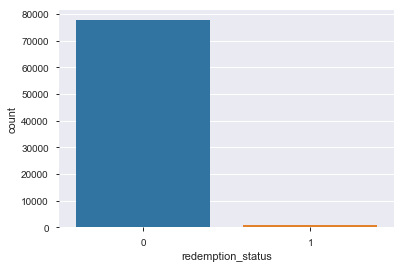

In [73]:
sns.countplot(mtrain['redemption_status'])
plt.show()

In [74]:
not_redeemed = len(mtrain[mtrain['redemption_status'] == 0])
redeemed = len(mtrain[mtrain['redemption_status'] == 1])
total = not_redeemed + redeemed

p_not_redeemed = (not_redeemed / total) * 100
p_redeemed = (redeemed / total) * 100

print(p_not_redeemed)
print(p_redeemed)

99.06978524671746
0.930214753282548


This is a highly imbalanced dataset

I tried Undersampling and Oversampling with SMOTE. But this did not affect the results much.  
In fact, it usually decreased my AUC.

### Train Test Split

In [75]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=1)

### Scaling

Scaling also reduced my AUC scores

## Classification

In [76]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score

In [77]:
def disp_confusion_matrix(model, x, y):
    ypred = model.predict(x)
    cm = confusion_matrix(y,ypred)
    ax = sns.heatmap(cm,annot=True,fmt='d')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    print('Accuracy =',accuracy)
    print('Precision =',precision)
    print('Recall =',recall)
    print('F1 Score =',f1)

In [78]:
def disp_roc_curve(model, xtest, ytest):
    yprob = model.predict_proba(xtest)
    fpr,tpr,threshold = roc_curve(ytest,yprob[:,1])
    roc_auc = roc_auc_score(ytest,yprob[:,1])

    print('ROC AUC =', roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

### Logistic Regression

Firstly, trying the most basic Classification Model

In [79]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(xtrain,ytrain)
print('Training set score = {:.3f}'.format(logreg.score(xtrain,ytrain)))
print('Test set score = {:.3f}'.format(logreg.score(xtest,ytest)))

Training set score = 0.991
Test set score = 0.990


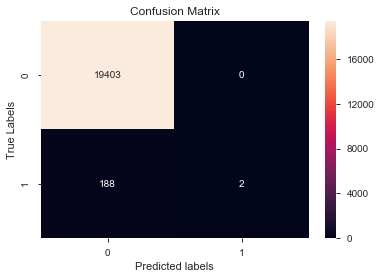

Accuracy = 0.9904047363854438
Precision = 1.0
Recall = 0.010526315789473684
F1 Score = 0.020833333333333332
ROC AUC = 0.7391839840285144


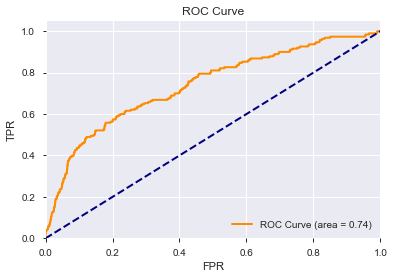

In [80]:
disp_confusion_matrix(logreg, xtest, ytest)
disp_roc_curve(logreg, xtest, ytest)

We get **terrible** Recall and F1 scores. But a decent ROC AUC.

In [81]:
logreg.fit(x,y)
test_prob = logreg.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-lr.csv',index=False)

### Random Forests

Let's try Random Forests, my favorite one.

In [82]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
print('Training set score = {:.3f}'.format(rf.score(xtrain,ytrain)))
print('Test set score = {:.3f}'.format(rf.score(xtest,ytest)))

Training set score = 0.997
Test set score = 0.988


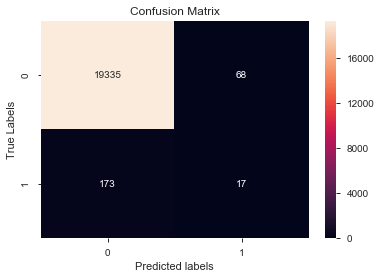

Accuracy = 0.9876996886643189
Precision = 0.2
Recall = 0.08947368421052632
F1 Score = 0.12363636363636364
ROC AUC = 0.7382170961083067


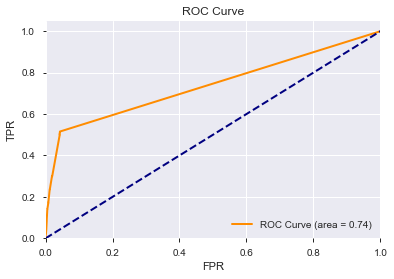

In [83]:
disp_confusion_matrix(rf, xtest, ytest)
disp_roc_curve(rf, xtest, ytest)

Better Recall and F1 scores but somehow worse ROC AUC.

In [84]:
rf.fit(x,y)
test_prob = rf.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-rf.csv',index=False)

In [85]:
pd.DataFrame({'Features':x.columns, 'Importance':rf.feature_importances_}).sort_values(by='Importance',ascending=False)

,Features,Importance
4,coupon_item_nunique,0.422964
15,coupon_discount_sum,0.052970
5,coupon_brand_nunique,0.044755
13,other_discount_sum,0.044640
16,coupon_discount_mean,0.044231
11,selling_price_sum,0.043633
12,selling_price_mean,0.042135
10,quantity_mean,0.040318
14,other_discount_mean,0.037346
8,date_nunique,0.035639


#### Parameter Tuning 

Let's try changing some parameters in Random Forest Classifier and see if we can improve our scores:

Firstly, lets see the effect of *n_estimators* parameter on the ROC AUC score:

100 : [0.8391624  0.84713783 0.84979807 0.84868232 0.80759429]
150 : [0.86376929 0.83951395 0.86052129 0.84300962 0.81412332]
200 : [0.88093228 0.83983639 0.87077409 0.86385134 0.83366133]
250 : [0.8659633  0.86880262 0.8598645  0.86827463 0.84155141]


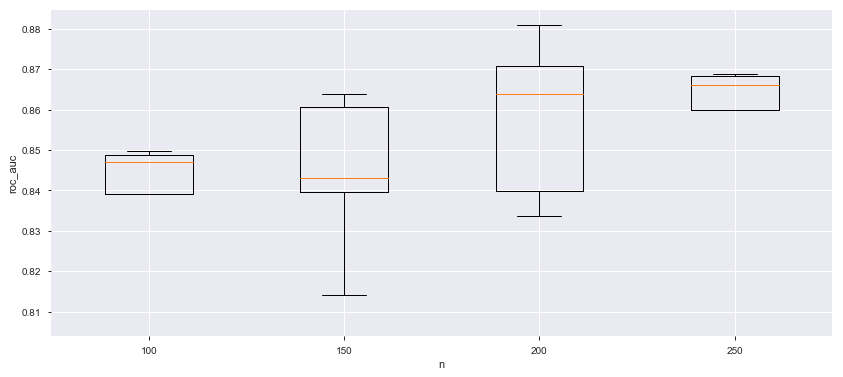

In [87]:
arr=[100,150,200,250]
cv_scores = []
for a in arr:
    model = RandomForestClassifier(n_estimators=a)
    cv_score = cross_val_score(model, x, y, cv=5, scoring='roc_auc')
    print(a, ':', cv_score)
    cv_scores.append(cv_score)
    
fig, ax = plt.subplots(figsize=(14,6))
plt.boxplot(cv_scores)
ax.set_xticklabels(arr)
plt.xlabel('n')
plt.ylabel('roc_auc')
plt.show()

I am choosing *n_estimators*=250 and performing a GridSearch for the other variables

In [88]:
param_grid = {'criterion': ['gini','entropy'],
              'max_depth': [None,5,10,15,20],
              'max_features': [None,5,10,15]}
rf = RandomForestClassifier(n_estimators=250)
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=4, verbose=2)
rf_grid.fit(x, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 10.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 50.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 63.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=250, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

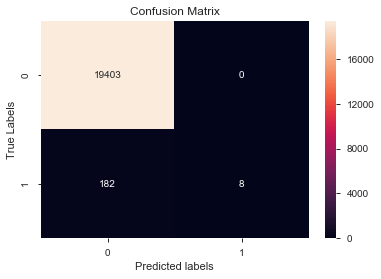

Accuracy = 0.9907109682029296
Precision = 1.0
Recall = 0.042105263157894736
F1 Score = 0.08080808080808081
ROC AUC = 0.990151143203574


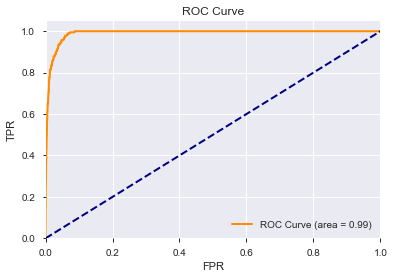

In [89]:
rf_best = rf_grid.best_estimator_
disp_confusion_matrix(rf_best, xtest, ytest)
disp_roc_curve(rf_best, xtest, ytest)

ROC AUC is much improved here; almost perfect

In [90]:
rf_best.fit(x,y)
test_prob = rf_best.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-rf2.csv',index=False)

### Gradient Boosting

Trying more advances ensemble methods could give us even better results

In [91]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(xtrain,ytrain)
print('Training set score = {:.3f}'.format(gb.score(xtrain,ytrain)))
print('Test set score = {:.3f}'.format(gb.score(xtest,ytest)))

Training set score = 0.992
Test set score = 0.990


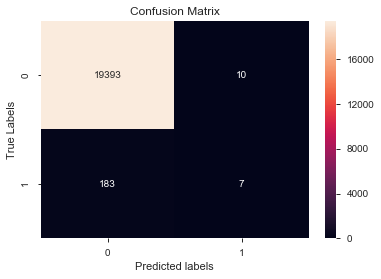

Accuracy = 0.9901495432042056
Precision = 0.4117647058823529
Recall = 0.03684210526315789
F1 Score = 0.06763285024154589
ROC AUC = 0.8979616554141112


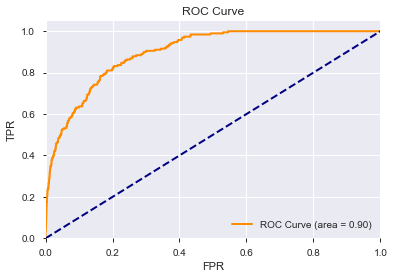

In [92]:
disp_confusion_matrix(gb, xtest, ytest)
disp_roc_curve(gb, xtest, ytest)

Decent AUC Score for a base model. It is promising.

In [93]:
gb.fit(x,y)
test_prob = gb.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-gb.csv',index=False)

### XGBoost 

Trying some advanced boosting methods

In [94]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(xtrain,ytrain)
print('Training set score = {:.3f}'.format(xgb.score(xtrain,ytrain)))
print('Test set score = {:.3f}'.format(xgb.score(xtest,ytest)))

Training set score = 0.991
Test set score = 0.991


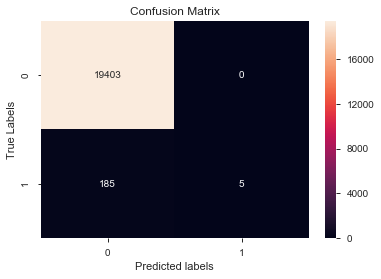

Accuracy = 0.9905578522941867
Precision = 1.0
Recall = 0.02631578947368421
F1 Score = 0.05128205128205127
ROC AUC = 0.9054609026818968


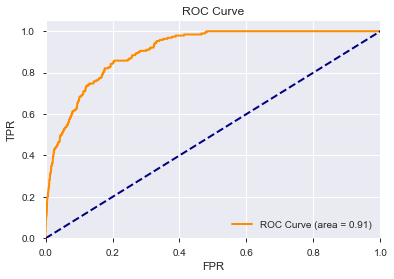

In [95]:
disp_confusion_matrix(xgb, xtest, ytest)
disp_roc_curve(xgb, xtest, ytest)

Great AUC score for a base model itself.  
Parameter Tuning could help us make this much better.

In [96]:
xgb.fit(x,y)
test_prob = xgb.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-xgb.csv',index=False)

#### Parameter Tuning

100 : [0.91800848 0.90529679 0.92253984 0.92852218 0.91360523]
150 : [0.92401001 0.91056787 0.92644772 0.93381267 0.92112069]
200 : [0.92732836 0.91267123 0.92893042 0.93573937 0.92370468]
250 : [0.93000735 0.91572846 0.92924933 0.93753441 0.92563378]


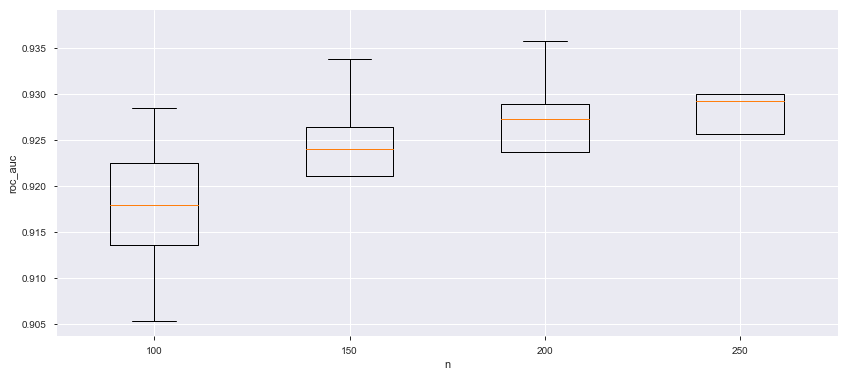

In [97]:
arr=[100,150,200,250]
cv_scores = []
for a in arr:
    model = XGBClassifier(objective='binary:logistic', n_jobs=4, n_estimators=a)
    cv_score = cross_val_score(model, x, y, cv=5, scoring='roc_auc')
    print(a, ':', cv_score)
    cv_scores.append(cv_score)
    
fig, ax = plt.subplots(figsize=(14,6))
plt.boxplot(cv_scores)
ax.set_xticklabels(arr)
plt.xlabel('n')
plt.ylabel('roc_auc')
plt.show()

In [98]:
param_grid = {
    'max_depth':[5,6],
    'subsample':[0.8,0.9,1],
    'colsample_bytree': [0.6,0.8,1],
    'min_child_weight': [0.5,1],
    'gamma': [0,0.5,1]
}
xgb = XGBClassifier(objective='binary:logistic', n_jobs=4, n_estimators=250)
xgb_grid = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=4)
xgb_grid.fit(x, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 31.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 78.9min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 99.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=250, n_jobs=4,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'gamma': [0, 0.5, 1], 'max_depth': [5, 6],
                         'min_child_weight

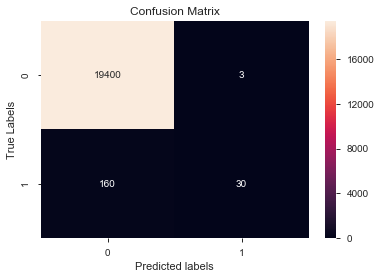

Accuracy = 0.9916807022916347
Precision = 0.9090909090909091
Recall = 0.15789473684210525
F1 Score = 0.26905829596412556
ROC AUC = 0.9851403879486893


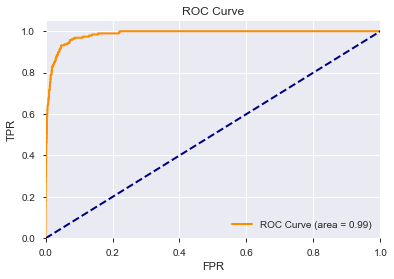

In [99]:
xgb_best = xgb_grid.best_estimator_
disp_confusion_matrix(xgb_best, xtest, ytest)
disp_roc_curve(xgb_best, xtest, ytest)

Excellent AUC along with improved Recall and F1 scores.  
This is the best result so far.

In [100]:
xgb_best.fit(x,y)
test_prob = xgb_best.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-xgb2.csv',index=False)

### LG Boost

In [101]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(xtrain,ytrain)
print('Training set score = {:.3f}'.format(lgb.score(xtrain,ytrain)))
print('Test set score = {:.3f}'.format(lgb.score(xtest,ytest)))

Training set score = 0.992
Test set score = 0.988


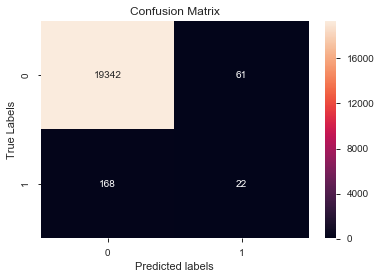

Accuracy = 0.9883121522992906
Precision = 0.26506024096385544
Recall = 0.11578947368421053
F1 Score = 0.16117216117216118
ROC AUC = 0.9199883631668462


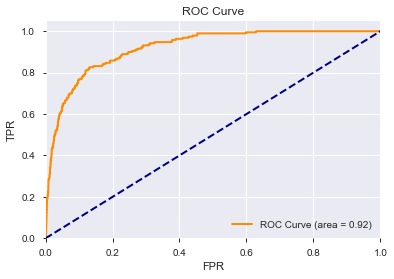

In [102]:
disp_confusion_matrix(lgb, xtest, ytest)
disp_roc_curve(lgb, xtest, ytest)

Good AUC score, but let's try to improve that by using GridSearch

In [103]:
lgb.fit(x,y)
test_prob = lgb.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-lgb.csv',index=False)

#### Parameter Tuning

-1 : [0.92916177 0.9183801  0.93232486 0.93632162 0.91897906]
10 : [0.93150376 0.9199676  0.92753479 0.93795808 0.90515776]
20 : [0.92910752 0.9183801  0.93232486 0.93632162 0.91897906]
30 : [0.92916177 0.9183801  0.93232486 0.93632162 0.91897906]
50 : [0.92916177 0.9183801  0.93232486 0.93632162 0.91897906]


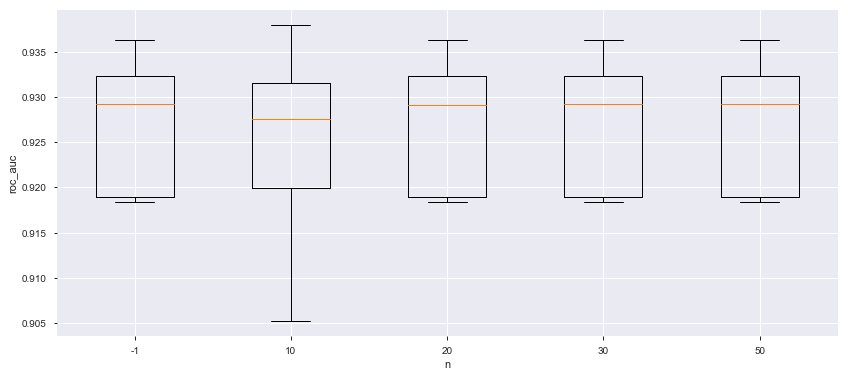

In [104]:
arr=[-1,10,20,30,50]
cv_scores = []
for a in arr:
    model = LGBMClassifier(objective='binary', n_jobs=4, boosting_type='gbdt', n_estimators=100, max_depth=a)
    cv_score = cross_val_score(model, x, y, cv=5, scoring='roc_auc')
    print(a, ':', cv_score)
    cv_scores.append(cv_score)
    
fig, ax = plt.subplots(figsize=(14,6))
plt.boxplot(cv_scores)
ax.set_xticklabels(arr)
plt.xlabel('n')
plt.ylabel('roc_auc')
plt.show()

In [105]:
param_grid = {
    'num_leaves':[40,60],
    'max_depth':[-1,10],
    'subsample':[0.8,0.9,1],
    'colsample_bytree': [0.6,0.8,1],
    'min_child_samples': [20,10,30],
    'min_split_gain':[0,0.5,1]
}
lgb = LGBMClassifier(objective='binary', n_jobs=4, boosting_type='gbdt', learning_rate=0.01, n_estimators=100, silent=False)
lgb_grid = GridSearchCV(lgb, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=4)
lgb_grid.fit(x, y)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done 1620 out of 1620 | elapsed: 21.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.01, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=4, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_l...=0.0,
                                      silent=False, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [

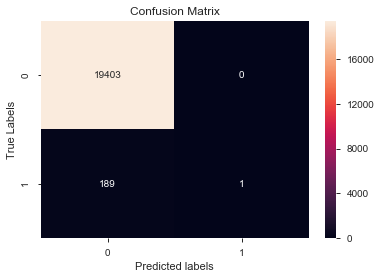

Accuracy = 0.9903536977491961
Precision = 1.0
Recall = 0.005263157894736842
F1 Score = 0.010471204188481674
ROC AUC = 0.9699577113685621


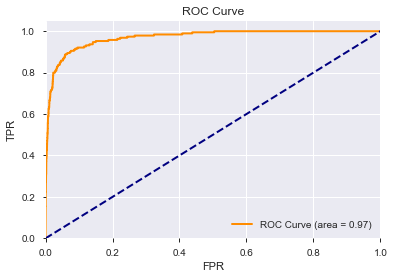

In [106]:
lgb_best = lgb_grid.best_estimator_
disp_confusion_matrix(lgb_best, xtest, ytest)
disp_roc_curve(lgb_best, xtest, ytest)

Improved AUC, but Recall and F1 score is not great.

In [107]:
lgb_best.fit(x,y)
test_prob = lgb_best.predict_proba(mtest)[:,1]
df = pd.DataFrame({'id':test_ids,'redemption_status':test_prob})
df.to_csv('submissions/submission-lgb.csv',index=False)

## Conclusion

From all the models, I tried XGBoost gives the best result here.  
This is also confired with the scores gotten upon submission

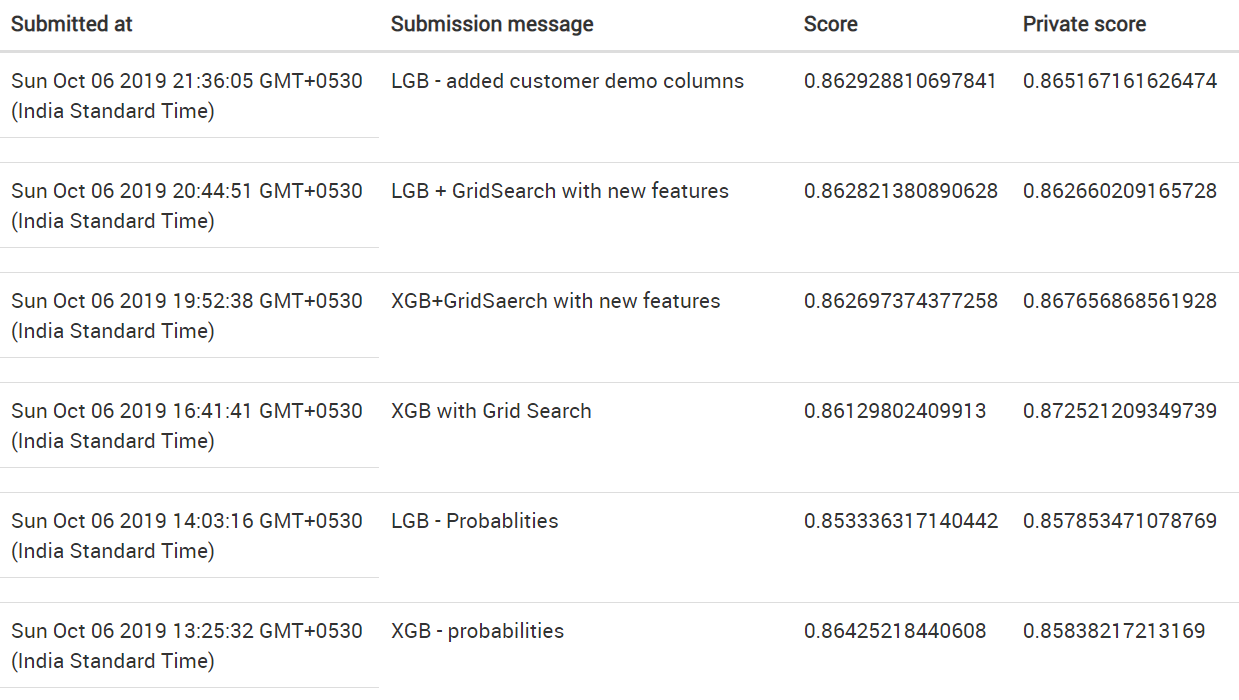

In [2]:
Image('images/scores.PNG')

XGB gives slightly better results on the test set than LGBM does.